In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
from torchvision import datasets, transforms

import zipfile

import shutil
import os
import pandas as pd

device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

c:\Users\Fred\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:

class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 2):
        super(AlexNet, self).__init__()

        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.linear = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.convolutional(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return torch.softmax(x, 1)



In [4]:

model = AlexNet()
model = model.to(device)


In [5]:

img_list = os.listdir('data/closed/')
img_list.extend(os.listdir('data/open/'))
# img_list.extend(os.listdir('data/semi/'))


In [6]:

print("Images: ", len(img_list))


Images:  1600


In [7]:

# !rm -rf 'data/.ipynb_checkpoints/'

transform = transforms.Compose([
          transforms.Resize((360,640)),
          transforms.ToTensor()
          ])

batch_size = 64

doors_data = datasets.ImageFolder('data', transform=transform)

In [8]:
zed_data = datasets.ImageFolder('doorway', transform=transform)

In [9]:
zed_data.class_to_idx

{'Closed': 0, 'Open': 1}

In [10]:

print(doors_data.classes)
print(len(doors_data))

print(zed_data.classes)
print(len(zed_data))


['closed', 'open']
1600
['Closed', 'Open']
724


In [11]:

train_set, test_set = torch.utils.data.random_split(doors_data, [int(len(img_list) * 0.75), len(img_list) - int(len(img_list) * 0.75)])
train_data_size = len(train_set)
test_data_size = len(test_set)

print(train_data_size)
print(test_data_size)


1200
400


In [12]:
test_set = zed_data + test_set
test_data_size = len(test_set)

In [13]:

trainLoader = torch.utils.data.DataLoader(train_set,batch_size=64, shuffle=True)
testLoader  = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=True)


In [14]:

new_testLoader = torch.utils.data.DataLoader(zed_data, batch_size=256, shuffle=False)

In [15]:

print(train_data_size)
print(test_data_size)


1200
1124


In [16]:
model = AlexNet()
model = model.to(device)
model.load_state_dict(torch.load("./100epochs.pt"))
model.eval()

AlexNet(
  (convolutional): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (linear): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


In [17]:

optimizer = optim.Adam(model.parameters(), lr=0.0001) #learning rate 1e-4
criterion = nn.CrossEntropyLoss()

epochs = 100
train_loss = []

for epoch in range(epochs):
   
    total_train_loss = 0
    
    # training our model
    for idx, (image, label) in enumerate(trainLoader):
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)
    print(f'Epoch: {epoch} | Train Loss: {total_train_loss}')
torch.save(model.state_dict(), "./weights.pt")


Epoch: 0 | Train Loss: 0.39955389029101324
Epoch: 1 | Train Loss: 0.40185447115647166
Epoch: 2 | Train Loss: 0.4010306063451265
Epoch: 3 | Train Loss: 0.39255693398023905
Epoch: 4 | Train Loss: 0.3847751711544238
Epoch: 5 | Train Loss: 0.3855575621128082
Epoch: 6 | Train Loss: 0.38804420985673604
Epoch: 7 | Train Loss: 0.3657725390635039
Epoch: 8 | Train Loss: 0.3689902142474526
Epoch: 9 | Train Loss: 0.35997392472467926
Epoch: 10 | Train Loss: 0.36297078509079783
Epoch: 11 | Train Loss: 0.3567083744626296
Epoch: 12 | Train Loss: 0.34948562164055674
Epoch: 13 | Train Loss: 0.34693745092341777
Epoch: 14 | Train Loss: 0.34619464999751043
Epoch: 15 | Train Loss: 0.3436135555568494
Epoch: 16 | Train Loss: 0.34553328940742895
Epoch: 17 | Train Loss: 0.3422522560546273
Epoch: 18 | Train Loss: 0.3431067513792138
Epoch: 19 | Train Loss: 0.3530550175591519
Epoch: 20 | Train Loss: 0.3562359417739667
Epoch: 21 | Train Loss: 0.3518051458032508
Epoch: 22 | Train Loss: 0.33650473387617813
Epoch: 23 

In [17]:

plt.plot(train_loss)


NameError: name 'train_loss' is not defined

In [31]:

testLoader  = torch.utils.data.DataLoader(zed_data, batch_size=724, shuffle=True)

testiter = iter(new_testLoader)
images, labels = testiter.next()

with torch.no_grad():
  images, labels = images.to(device), labels.to(device)
  pred = model(images)

images_np = [i.cpu() for i in images]
class_names = doors_data.classes
print(labels)


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


In [32]:
len(testiter)


3

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255


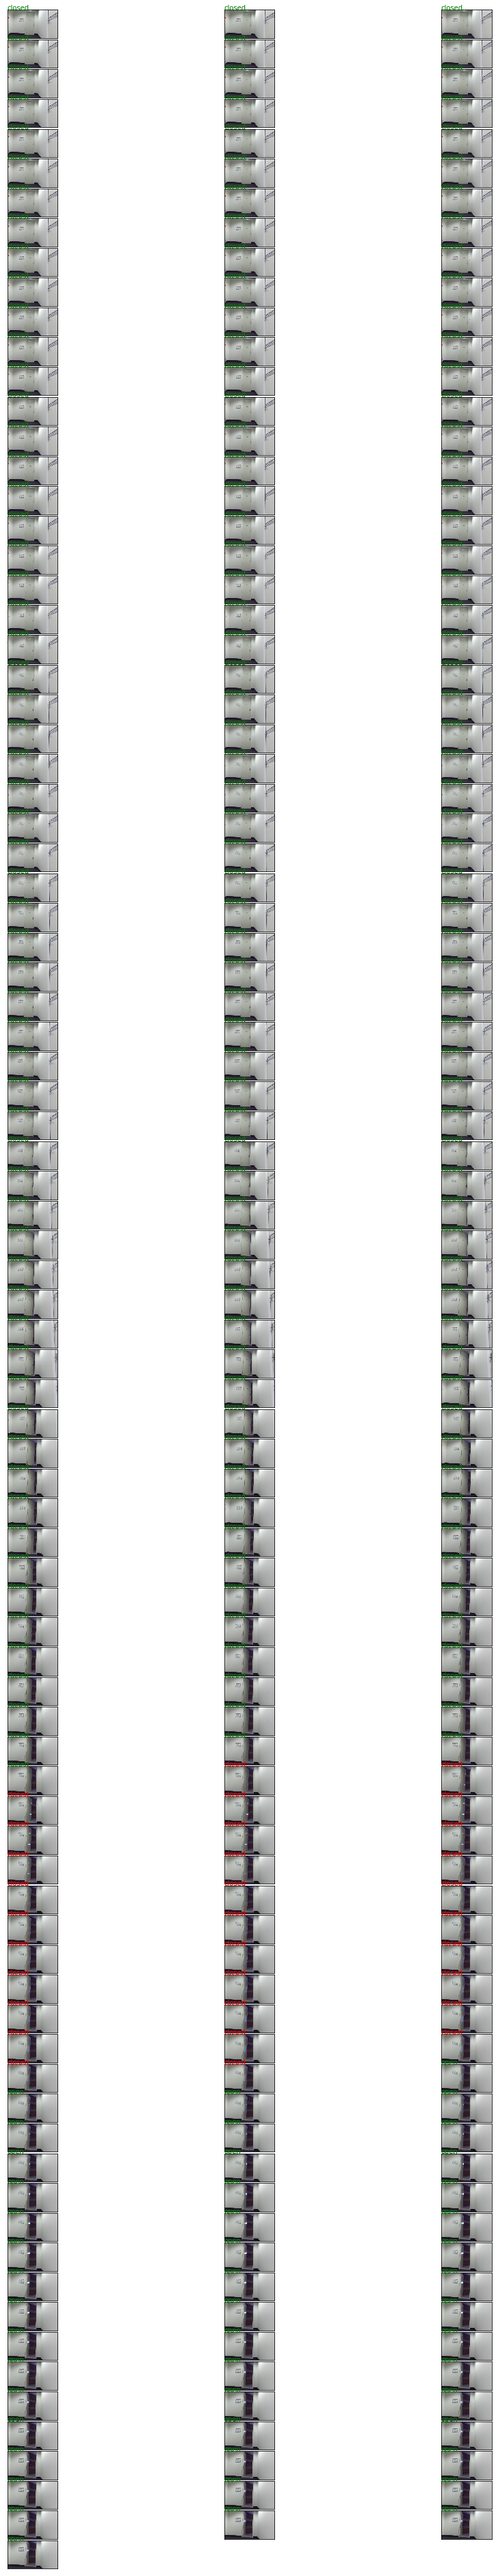

In [37]:
fig = plt.figure(figsize=(52, 52))
fig.subplots_adjust(left=0, right=0.25, bottom=0, top=1, hspace=0.05, wspace=0.05)
false_value = 0
num_images_disp = 256

for i in range(num_images_disp):
    print(i)
    # images_np[i] = images_np[i].numpy()
    ax = fig.add_subplot(86, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i].transpose(1, 2, 0), cmap=plt.cm.gray_r, interpolation='nearest')

    # fig2 = plt.figure(figsize=(15, 7))
    # fig2.show(images_np[i].transpose(1, 2, 0), cmap=plt.cm.gray_r, interpolation='nearest')

    if labels[i] == torch.max(pred[i], 0)[1]: #if the label matches the maximum probability of the model
        ax.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='green')
        # fig2.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='green')
    else:
        ax.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='red')
        # fig2.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='red')
        #counter for false reading of doorway
        false_value = false_value + 1



In [38]:
print(false_value/num_images_disp)

0.12109375
